In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader


In [2]:
DATA_DIR = "/kaggle/input/braintumor-cv/BrainTumor_cv"

IMG_TRAIN = os.path.join(DATA_DIR, "images/Train")
IMG_TEST  = os.path.join(DATA_DIR, "images/Test")
LBL_TRAIN = os.path.join(DATA_DIR, "labels/Train")
LBL_TEST  = os.path.join(DATA_DIR, "labels/Test")


In [3]:
def create_patches(img, label_path, patch_size=64, stride=64):
    """
    img: grayscale MRI image
    label_path: YOLO txt label file
    Returns: list of (patch, label)
    """
    h, w = img.shape[:2]
    
    # read bounding boxes
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x*w), int(y*h), int(bw*w), int(bh*h)
                x1, y1 = x - bw//2, y - bh//2
                x2, y2 = x + bw//2, y + bh//2
                boxes.append((x1,y1,x2,y2))
    
    patches, labels = [], []
    for i in range(0, h-patch_size, stride):
        for j in range(0, w-patch_size, stride):
            patch = img[i:i+patch_size, j:j+patch_size]
            
            # check overlap with tumor boxes
            patch_label = 0
            for (x1,y1,x2,y2) in boxes:
                if j < x2 and j+patch_size > x1 and i < y2 and i+patch_size > y1:
                    patch_label = 1
                    break
            
            patches.append(cv2.resize(patch, (224,224)))  # resize for GoogleNet
            labels.append(patch_label)
    
    return patches, labels


In [4]:
from sklearn.model_selection import train_test_split
import os
from glob import glob
import cv2
import numpy as np

def build_patch_dataset(img_dir, lbl_dir):
    X, y = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    
    for img_path in img_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg",".txt").replace(".png",".txt"))
        patches, labels = create_patches(img, lbl_path, patch_size=64, stride=64)
        X.extend(patches)
        y.extend(labels)
    
    return np.array(X), np.array(y)

# ---- LOAD TRAINING DATA ----
X_all, y_all = build_patch_dataset(IMG_TRAIN, LBL_TRAIN)

# ---- SPLIT TRAIN INTO TRAIN + VALIDATION ----
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# ---- LOAD TEST DATA ----
X_test, y_test = build_patch_dataset(IMG_TEST, LBL_TEST)

print("Train patches:", X_train.shape, "Labels:", np.unique(y_train, return_counts=True))
print("Val patches:", X_val.shape, "Labels:", np.unique(y_val, return_counts=True))
print("Test patches:", X_test.shape, "Labels:", np.unique(y_test, return_counts=True))


Train patches: (25204, 224, 224) Labels: (array([0, 1]), array([22943,  2261]))
Val patches: (6302, 224, 224) Labels: (array([0, 1]), array([5737,  565]))
Test patches: (8407, 224, 224) Labels: (array([0, 1]), array([7743,  664]))


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# --- Transformations ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # simple normalization for grayscale
])

# --- Convert numpy arrays → torch tensors ---
# Add channel dimension (grayscale → 3 channels for CNNs like GoogLeNet/VGG)
def prepare_tensors(X, y):
    X_torch = torch.tensor(X).unsqueeze(1).repeat(1, 3, 1, 1).float()  # (N,3,H,W)
    y_torch = torch.tensor(y).long()
    return X_torch, y_torch

X_train_torch, y_train_torch = prepare_tensors(X_train, y_train)
X_val_torch, y_val_torch     = prepare_tensors(X_val, y_val)
X_test_torch, y_test_torch   = prepare_tensors(X_test, y_test)

# --- Create TensorDatasets ---
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset   = TensorDataset(X_val_torch, y_val_torch)
test_dataset  = TensorDataset(X_test_torch, y_test_torch)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Sanity Check ---
print("✅ DataLoader Summary:")
print(f"Train set → {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Val set   → {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"Test set  → {len(test_dataset)} samples, {len(test_loader)} batches")


✅ DataLoader Summary:
Train set → 25204 samples, 788 batches
Val set   → 6302 samples, 197 batches
Test set  → 8407 samples, 263 batches


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# --- Load Pretrained GoogLeNet ---
# We are loading a pretrained GoogLeNet model from torchvision
# and replacing the final fully-connected layer to have 2 outputs (tumor / no tumor)
googlenet = models.googlenet(weights='IMAGENET1K_V1')  # pretrained weights
googlenet.fc = nn.Linear(googlenet.fc.in_features, 2)  # 2 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

# --- Loss function & Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.0001)

# --- Training Loop ---
num_epochs = 5

for epoch in range(num_epochs):
    # ===== TRAINING PHASE =====
    # Here we load our training data (train_loader) into the model
    googlenet.train()
    total_train, correct_train = 0, 0
    running_loss_train = 0.0

    for images, labels in train_loader:  # train_loader contains our training set
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute metrics
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        running_loss_train += loss.item()
    
    train_acc = 100 * correct_train / total_train
    train_loss = running_loss_train / len(train_loader)

    # ===== VALIDATION PHASE =====
    # Here we load our validation data (val_loader) into the model
    googlenet.eval()
    total_val, correct_val = 0, 0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in val_loader:  # val_loader contains our validation set
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            running_loss_val += loss.item()
    
    val_acc = 100 * correct_val / total_val
    val_loss = running_loss_val / len(val_loader)

    # ===== PRINT EPOCH RESULTS =====
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("✅ Training Complete!")


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 88.7MB/s]


Epoch [1/5] Train Loss: 0.1436 | Train Acc: 94.34% | Val Loss: 0.0940 | Val Acc: 96.40%
Epoch [2/5] Train Loss: 0.0957 | Train Acc: 96.72% | Val Loss: 0.0870 | Val Acc: 96.81%
Epoch [3/5] Train Loss: 0.0812 | Train Acc: 97.16% | Val Loss: 0.0760 | Val Acc: 97.38%
Epoch [4/5] Train Loss: 0.0711 | Train Acc: 97.53% | Val Loss: 0.0843 | Val Acc: 97.21%
Epoch [5/5] Train Loss: 0.0610 | Train Acc: 97.88% | Val Loss: 0.0769 | Val Acc: 97.65%
✅ Training Complete!


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Put the model in evaluation mode
googlenet.eval()

all_preds = []
all_labels = []
#IMG_TEST  = os.path.join(DATA_DIR, "images/Test")
#LBL_TEST  = os.path.join(DATA_DIR, "labels/Test")
#X_test, y_test = build_patch_dataset(IMG_TEST, LBL_TEST)
#X_test_torch, y_test_torch   = prepare_tensors(X_test, y_test)
#test_dataset  = TensorDataset(X_test_torch, y_test_torch)
#test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    for images, labels in test_loader:  # test_loader contains our test set
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Compute metrics ---
test_acc = accuracy_score(all_labels, all_preds) * 100
test_precision = precision_score(all_labels, all_preds, average='binary') * 100
test_recall = recall_score(all_labels, all_preds, average='binary') * 100
test_f1 = f1_score(all_labels, all_preds, average='binary') * 100
test_cm = confusion_matrix(all_labels, all_preds)

# --- Print results ---
print("✅ Test Set Evaluation:")
print(f"Accuracy: {test_acc:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall: {test_recall:.2f}%")
print(f"F1 Score: {test_f1:.2f}%")
print("Confusion Matrix:")
print(test_cm)


✅ Test Set Evaluation:
Accuracy: 96.98%
Precision: 88.97%
Recall: 70.48%
F1 Score: 78.66%
Confusion Matrix:
[[7685   58]
 [ 196  468]]


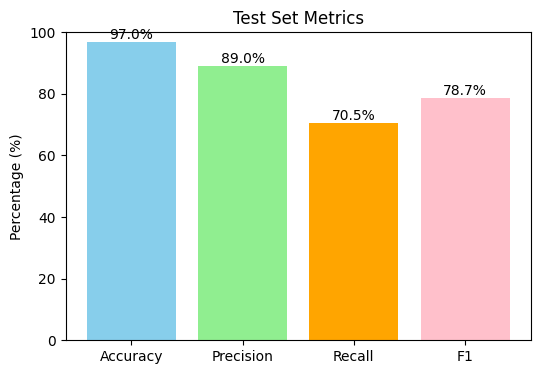

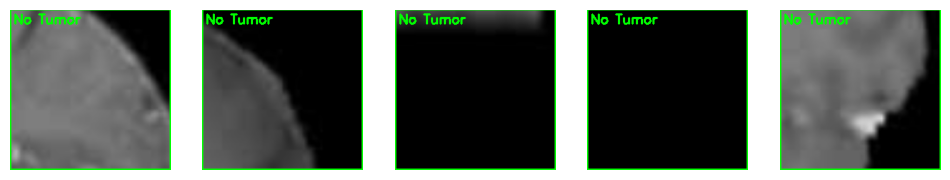

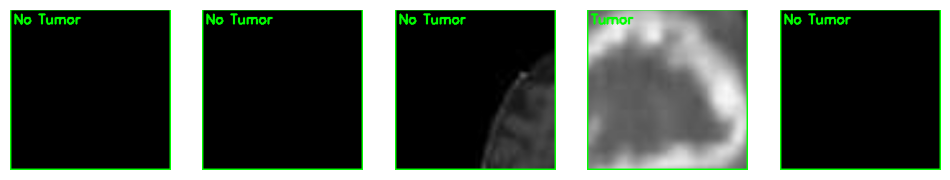

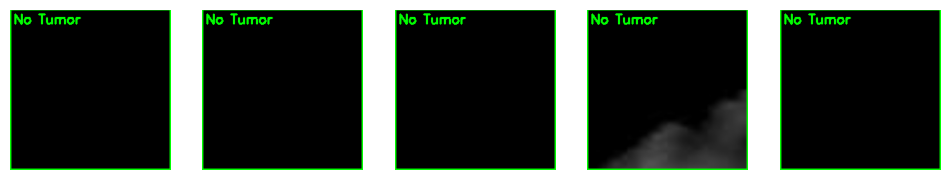

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ---------- 1️⃣ Bar plot of test metrics ----------
metrics = [test_acc, test_precision, test_recall, test_f1]
names = ['Accuracy', 'Precision', 'Recall', 'F1']
plt.figure(figsize=(6,4))
plt.bar(names, metrics, color=['skyblue','lightgreen','orange','pink'])
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.title("Test Set Metrics")
for i, v in enumerate(metrics):
    plt.text(i, v+1, f"{v:.1f}%", ha='center')
plt.show()

# ---------- 2️⃣ Visualize Sample Predictions ----------
def visualize_samples(X_numpy, y_true, model, n_samples=5, device=device):
    model.eval()
    indices = np.random.choice(len(X_numpy), n_samples, replace=False)
    X_samples = torch.tensor(X_numpy[indices]).unsqueeze(1).repeat(1,3,1,1).float().to(device)
    y_samples = y_true[indices]

    with torch.no_grad():
        outputs = model(X_samples)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()

    plt.figure(figsize=(12,4))
    for i in range(n_samples):
        img = X_numpy[indices[i]].astype(np.uint8)
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Draw bounding box over the patch
        h, w = img.shape
        color = (0,255,0) if preds[i]==y_samples[i] else (0,255,255)  # green correct, yellow wrong
        cv2.rectangle(img_color, (0,0), (w-1,h-1), color, 2)

        # Prediction text
        label = "Tumor" if preds[i]==1 else "No Tumor"
        cv2.putText(img_color, label, (5,20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        plt.subplot(1,n_samples,i+1)
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Visualize 5 samples from Train, Validation, and Test
visualize_samples(X_train, y_train, googlenet, n_samples=5)
visualize_samples(X_val, y_val, googlenet, n_samples=5)
visualize_samples(X_test, y_test, googlenet, n_samples=5)


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, X_tensor, y_tensor, device, dataset_name="Dataset"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(X_tensor)):
            x = X_tensor[i].unsqueeze(0).to(device)
            label = y_tensor[i].item()

            output = model(x)
            pred = output.argmax(1).item()

            all_preds.append(pred)
            all_labels.append(label)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Tumor (0)", "Tumor (1)"])
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", colorbar=True)
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    return cm


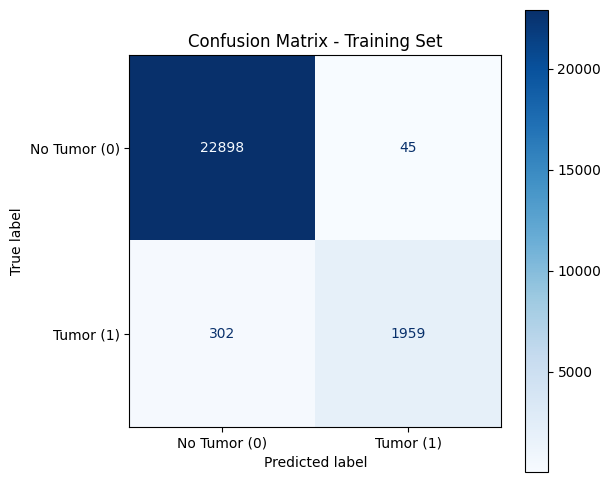

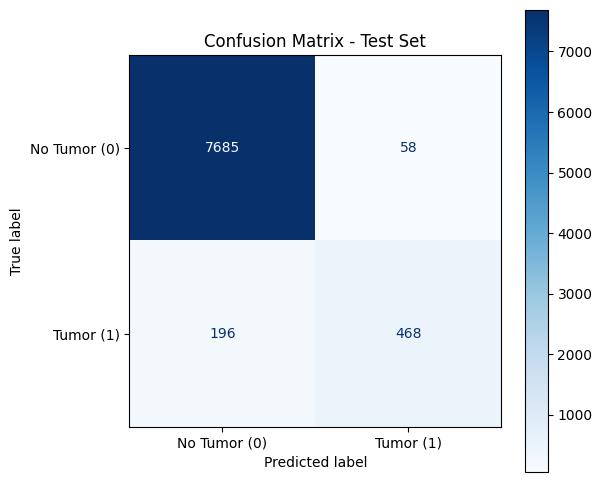

In [10]:
# For training set
cm_train = plot_confusion_matrix(googlenet, X_train_torch, y_train_torch, device, "Training Set")

# For test set
cm_test = plot_confusion_matrix(googlenet, X_test_torch, y_test_torch, device, "Test Set")


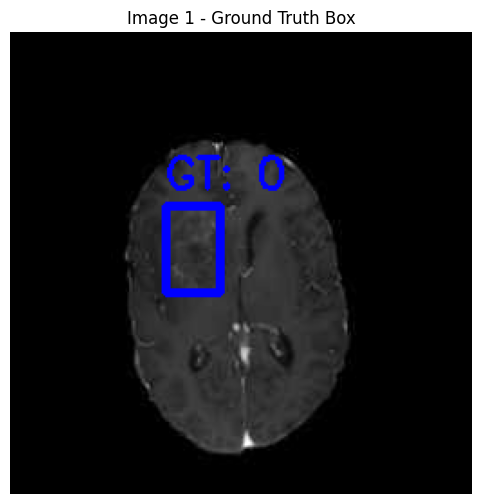

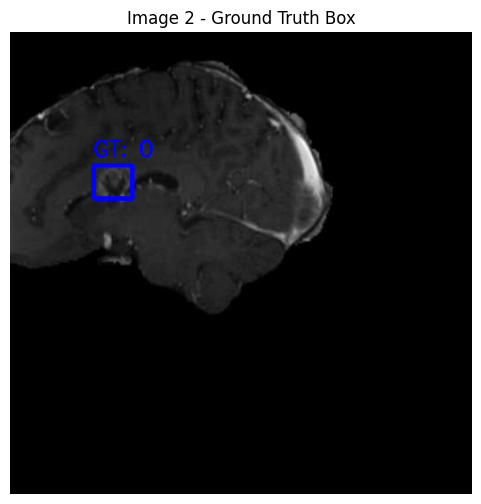

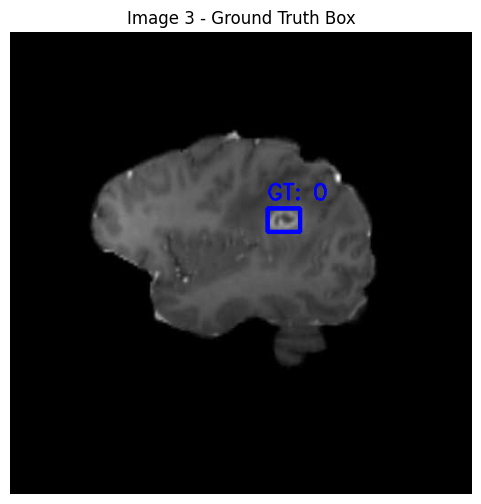

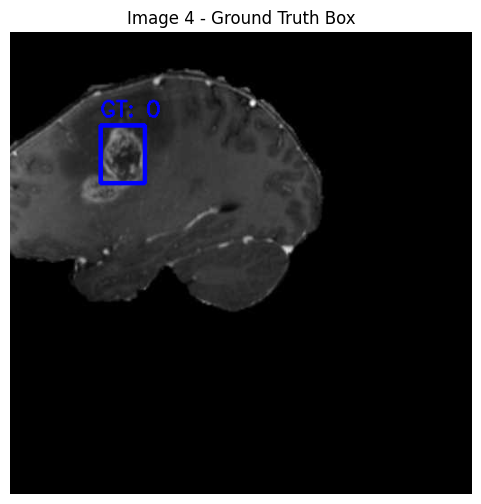

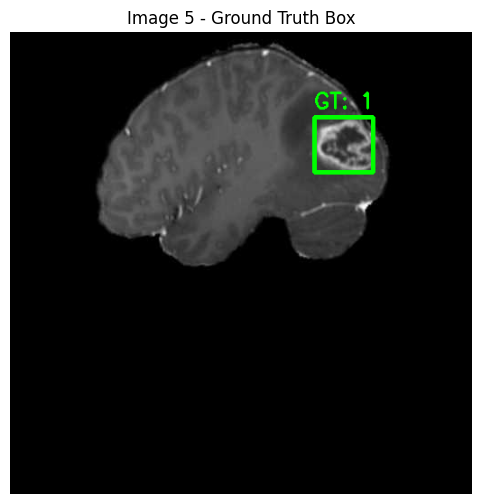

In [11]:
import os
import cv2
import matplotlib.pyplot as plt

IMG_TEST = "/kaggle/input/braintumor-cv/BrainTumor_cv/images/Test"
LBL_TEST = "/kaggle/input/braintumor-cv/BrainTumor_cv/labels/Test"

test_imgs = [f for f in os.listdir(IMG_TEST) if f.endswith((".jpg",".png",".jpeg"))]

def show_test_images_with_gt(img_dir, lbl_dir, img_list, num_images=5):
    for i, img_name in enumerate(img_list[:num_images]):
        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(lbl_dir, img_name.replace(".jpg",".txt"))  # adjust extension if needed

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Load label
        if not os.path.exists(label_path):
            print(f"Label not found for {img_name}, skipping...")
            continue

        with open(label_path, "r") as f:
            line = f.readline().strip()
            cls, x_c, y_c, bw, bh = map(float, line.split())

        # Convert normalized bbox to pixels
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)

        # Clip to image boundaries
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        # Draw bbox
        color = (0, 255, 0) if cls == 1 else (0, 0, 255)
        img_copy = img.copy()
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 3)
        cv2.putText(img_copy, f"GT: {int(cls)}", (x1, max(15, y1-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        # Show image
        plt.figure(figsize=(6,6))
        plt.imshow(img_copy)
        plt.axis("off")
        plt.title(f"Image {i+1} - Ground Truth Box")
        plt.show()

# Example usage
show_test_images_with_gt(IMG_TEST, LBL_TEST, test_imgs, num_images=5)


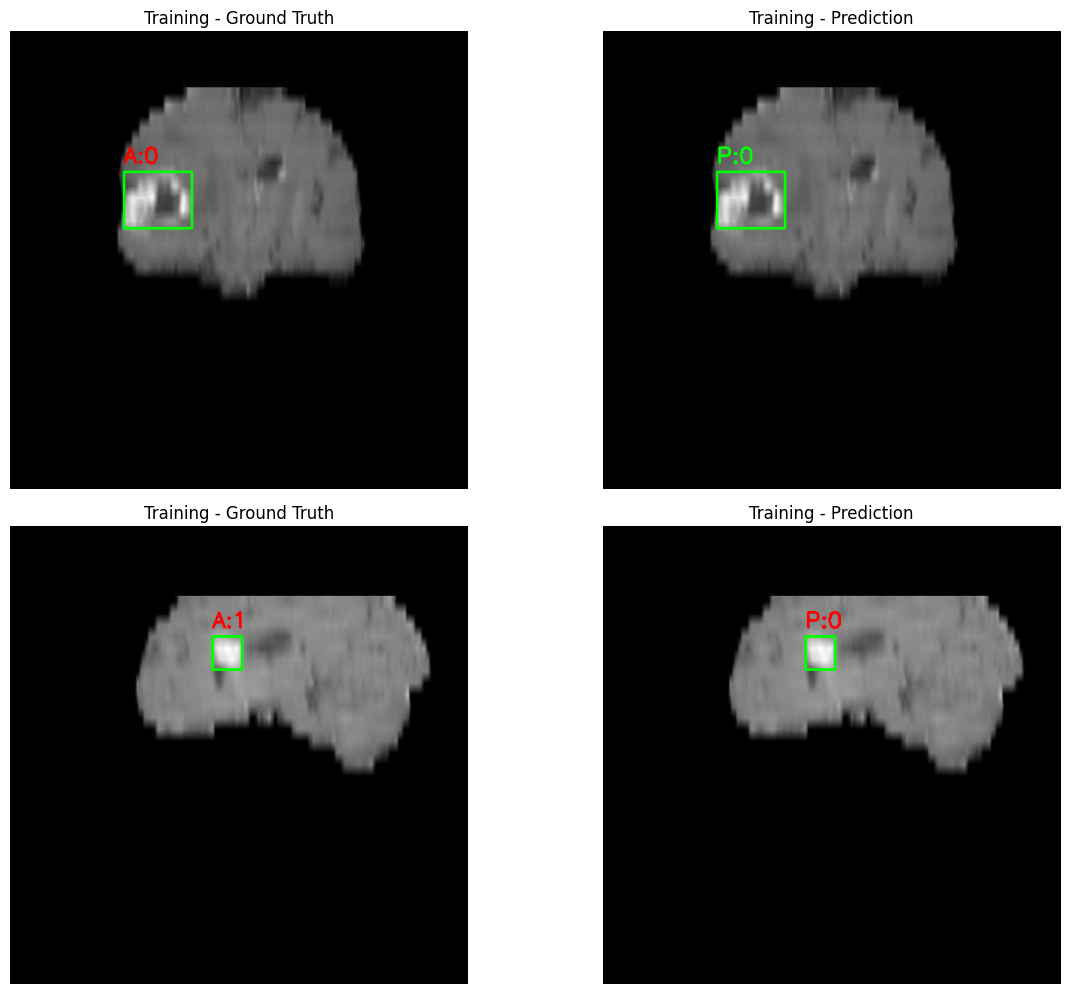

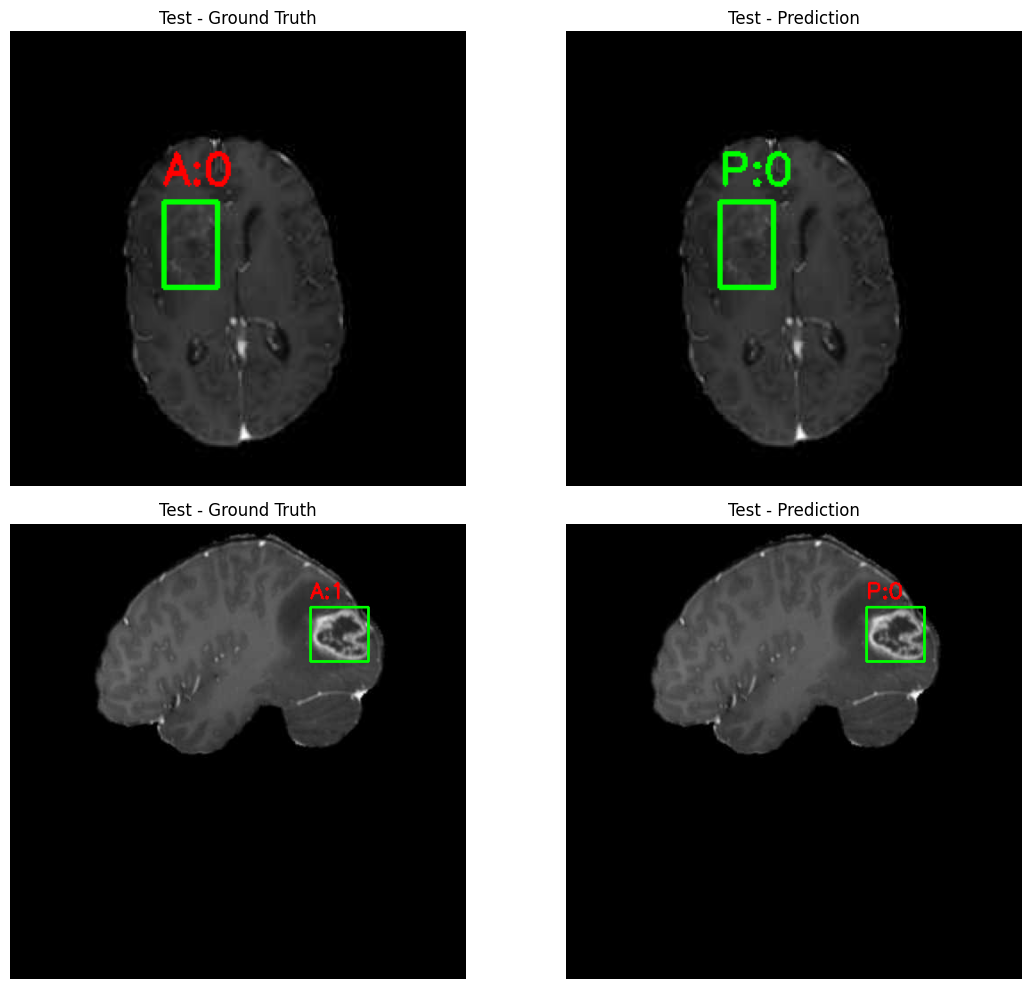

In [12]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Paths according to your dataset ---
DATA_DIR = "/kaggle/input/braintumor-cv/BrainTumor_cv"

IMG_TRAIN = os.path.join(DATA_DIR, "images", "Train")
IMG_TEST  = os.path.join(DATA_DIR, "images", "Test")
LBL_TRAIN = os.path.join(DATA_DIR, "labels", "Train")
LBL_TEST  = os.path.join(DATA_DIR, "labels", "Test")

# --- Visualization function ---
def visualize_samples_balanced(img_paths, model, labels_dir, device, num_images=10, dataset_name="Dataset"):
    """
    Visualize a balanced set of images including both tumor and non-tumor,
    with correct/incorrect predictions.
    """
    model.eval()
    plt.figure(figsize=(12, num_images * 5))
    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    
    count = 0
    tumor_count = 0
    non_tumor_count = 0

    for img_path in img_paths:
        if count >= num_images:
            break

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Read label file
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(labels_dir, base_name + ".txt")
        if not os.path.exists(label_file):
            continue
        
        with open(label_file, "r") as f:
            line = f.readline().strip()
            parts = line.split()
            label = int(parts[0])  # 0 = non-tumor, 1 = tumor
            x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Skip if we already have enough of this class
        if label == 1 and tumor_count >= num_images//2:
            continue
        if label == 0 and non_tumor_count >= num_images//2:
            continue
        
        # Convert bbox to pixel coordinates
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Predict class
        img_tensor = preprocess(img).to(device)
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))
            pred_class = output.argmax(1).item()
        
        # Copy image for left/right display
        img_left = img.copy()
        img_right = img.copy()
        
        # Draw bounding boxes
        cv2.rectangle(img_left, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.rectangle(img_right, (x1, y1), (x2, y2), (0,255,0), 2)
        
        # Add only label text
        cv2.putText(img_left, f"A:{label}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        color = (0,255,0) if pred_class == label else (255,0,0)
        cv2.putText(img_right, f"P:{pred_class}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        # Plot side by side
        plt.subplot(num_images, 2, count*2 + 1)
        plt.imshow(img_left)
        plt.axis("off")
        plt.title(f"{dataset_name} - Ground Truth")
        
        plt.subplot(num_images, 2, count*2 + 2)
        plt.imshow(img_right)
        plt.axis("off")
        plt.title(f"{dataset_name} - Prediction")
        
        count += 1
        if label == 1:
            tumor_count += 1
        else:
            non_tumor_count += 1
    
    plt.tight_layout()
    plt.show()

# --- Example usage ---
train_imgs = [os.path.join(IMG_TRAIN, f) for f in os.listdir(IMG_TRAIN)]
test_imgs  = [os.path.join(IMG_TEST, f) for f in os.listdir(IMG_TEST)]

# Visualize balanced samples
visualize_samples_balanced(train_imgs, googlenet, LBL_TRAIN, device, num_images=3, dataset_name="Training")
visualize_samples_balanced(test_imgs, googlenet, LBL_TEST, device, num_images=2, dataset_name="Test")


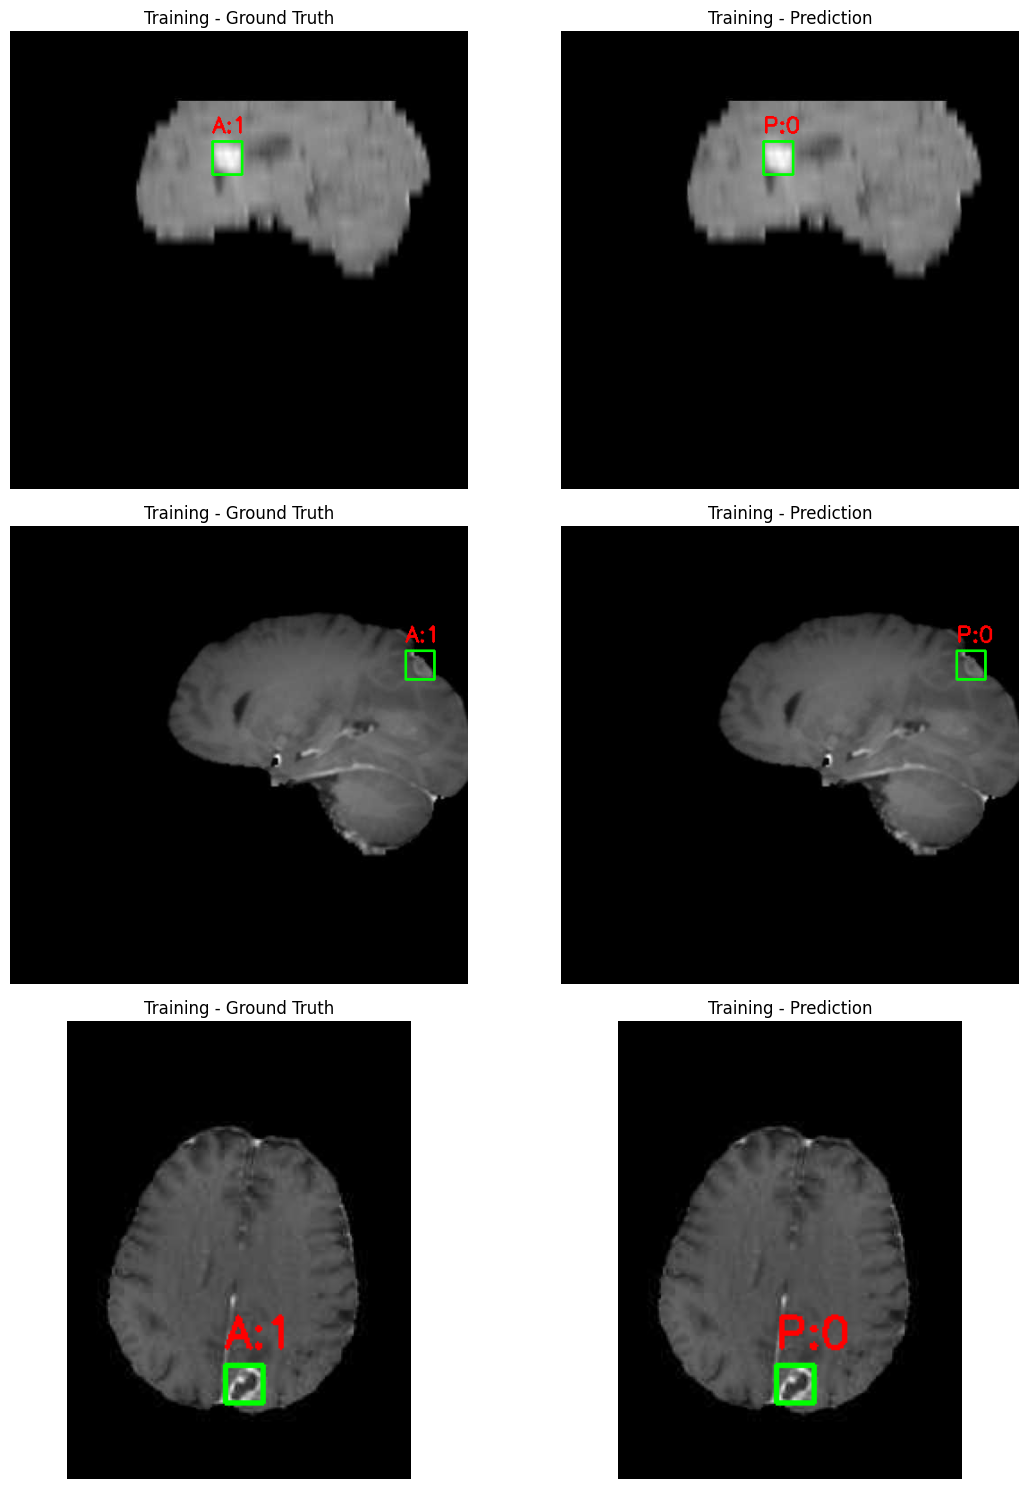

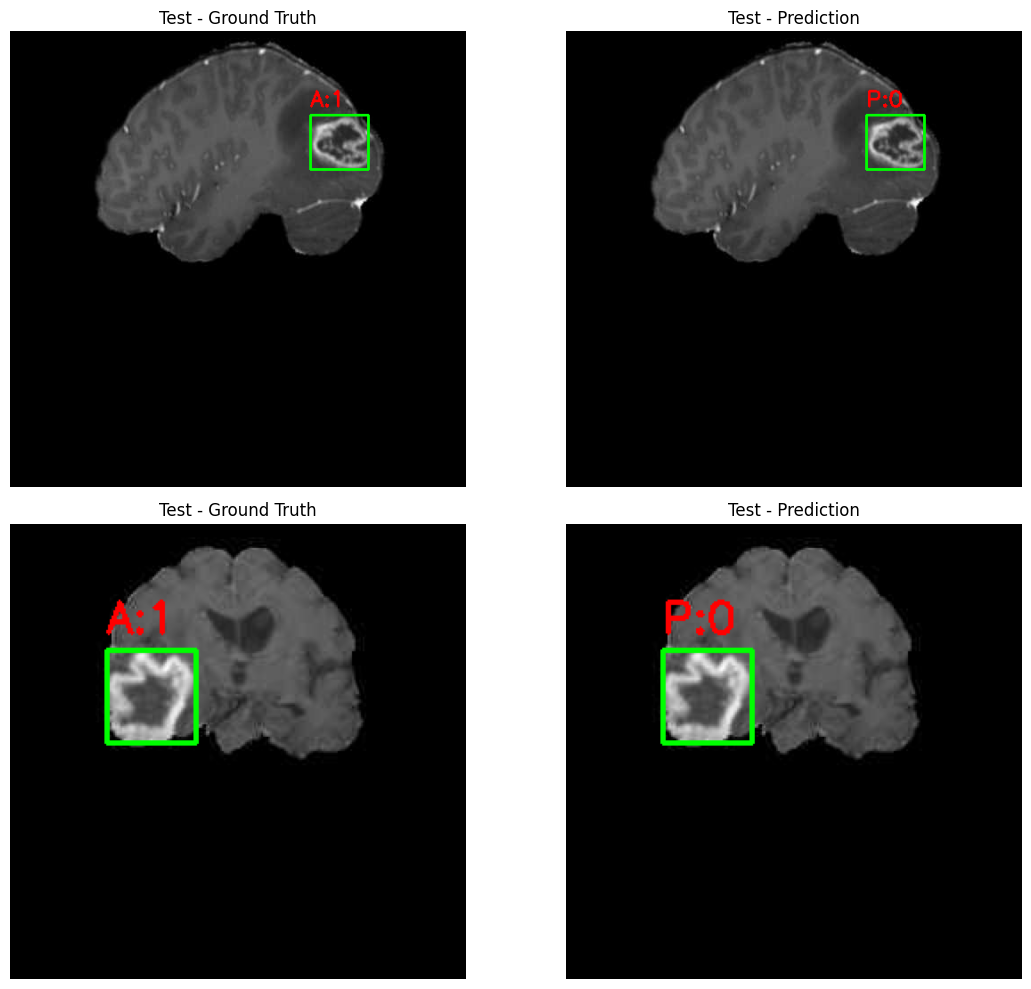

''

In [16]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Paths according to your dataset ---
DATA_DIR = "/kaggle/input/braintumor-cv/BrainTumor_cv"

IMG_TRAIN = os.path.join(DATA_DIR, "images", "Train")
IMG_TEST  = os.path.join(DATA_DIR, "images", "Test")
LBL_TRAIN = os.path.join(DATA_DIR, "labels", "Train")
LBL_TEST  = os.path.join(DATA_DIR, "labels", "Test")

# --- Visualization function for tumor images only ---
def visualize_tumor_images(img_paths, model, labels_dir, device, num_images=10, dataset_name="Dataset"):
    """
    Visualize only tumor images (label=1) with their ground truth and predictions.
    """
    model.eval()
    plt.figure(figsize=(12, num_images * 5))
    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    
    count = 0
    for img_path in img_paths:
        if count >= num_images:
            break

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Read label
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(labels_dir, base_name + ".txt")
        if not os.path.exists(label_file):
            continue
        
        with open(label_file, "r") as f:
            line = f.readline().strip()
            parts = line.split()
            label = int(parts[0])  # 0 = non-tumor, 1 = tumor
            x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Skip non-tumor images
        if label != 1:
            continue
        
        # Convert bbox to pixel coordinates
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Predict class
        img_tensor = preprocess(img).to(device)
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))
            pred_class = output.argmax(1).item()
        
        # Copy image for left/right display
        img_left = img.copy()
        img_right = img.copy()
        
        # Draw bounding boxes
        cv2.rectangle(img_left, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.rectangle(img_right, (x1, y1), (x2, y2), (0,255,0), 2)
        
        # Add label text
        cv2.putText(img_left, f"A:{label}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        color = (0,255,0) if pred_class == label else (255,0,0)
        cv2.putText(img_right, f"P:{pred_class}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        # Plot side by side
        plt.subplot(num_images, 2, count*2 + 1)
        plt.imshow(img_left)
        plt.axis("off")
        plt.title(f"{dataset_name} - Ground Truth")
        
        plt.subplot(num_images, 2, count*2 + 2)
        plt.imshow(img_right)
        plt.axis("off")
        plt.title(f"{dataset_name} - Prediction")
        
        count += 1
    
    plt.tight_layout()
    plt.show()

# --- Example usage ---
train_imgs = [os.path.join(IMG_TRAIN, f) for f in os.listdir(IMG_TRAIN)]
test_imgs  = [os.path.join(IMG_TEST, f) for f in os.listdir(IMG_TEST)]

# Visualize only tumor images
visualize_tumor_images(train_imgs, googlenet, LBL_TRAIN, device, num_images=3, dataset_name="Training")
visualize_tumor_images(test_imgs, googlenet, LBL_TEST, device, num_images=2, dataset_name="Test")
""